In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from lib.data import generate_top_n_for_all_users, get_ratings, get_predictions, get_top_n, get_relevant_items_for_user, set_items, get_users, set_ratings, set_predictions

# Metric Imports
from lib.availability import availability_for_user
from lib.coverage import is_user_covered, category_coverage_for_user
from lib.diversity import intralist_price_diversity_for_user, intralist_category_diversity_for_user
from lib.mrr import mrr_for_user
from lib.precision import average_precision_for_user, f1_score
from lib.rmse import rmse_for_user
from lib.serendipity import serendipity_for_user
from lib.ndcg import ndcg

from lib.utils import read_items_from_file, read_ratings_from_file, read_predictions_from_file, calculate_statistics, generate_output_files

In [13]:
BASELINE_ALGORITHMS = ['cbf', 'mf', 'item-item']
WEIGHTS = [0.10, 0.25, 0.50, 0.75, 0.85, 0.90, 0.95]

algorithms_to_study = []

for weight in WEIGHTS:
    for algorithm_1 in BASELINE_ALGORITHMS:
        for algorithm_2 in BASELINE_ALGORITHMS:
            if algorithm_1 != algorithm_2:
                algorithms_to_study.append('weight_%s_%d_%s' % (algorithm_2, weight*100, algorithm_1))
                
ALGORITHMS = ['user-user'] + BASELINE_ALGORITHMS + algorithms_to_study

SINGLEVALUE_METRICS = ['Coverage.Item', 'Coverage.User']
MULTIVALUE_METRICS = ['Availability', 'MRR', 'Serendipity',
                    'MAP', 'RMSE.Predict', 'RMSE.TopN', 'nDCG', 'Diversity.Price', 'Diversity.Category', 'F1']

set_ratings(read_ratings_from_file())
ITEMS = read_items_from_file()
set_items(ITEMS)
ALL_CATEGORIES = set(map(lambda x: x['Category'], ITEMS))

results = {}

for metric in (SINGLEVALUE_METRICS + MULTIVALUE_METRICS):
  results[metric] = {}

for algorithm in ALGORITHMS:
  predictions = read_predictions_from_file(algorithm)
  set_predictions(predictions)

  users = get_users()
  generate_top_n_for_all_users(users)

  items_recommended = set()
  users_covered = 0.0

  availability_values = []
  mrr_values = []
  serendipity_values = []
  map_values = []
  f1_values = []
  rmse_predict_values = []
  rmse_top_values = []
  ndcg_values = []
  diversity_price_values = []
  diversity_category_values = []

  for user_id in users:
    top_n = get_top_n(user_id, 5)
    user_ratings = get_ratings(user_id)
    user_relevant_items = get_relevant_items_for_user(user_id)
    user_predictions = get_predictions(user_id)

    # Coverage Metrics
    items_recommended = items_recommended | set(top_n['Item'])

    if is_user_covered(top_n):
      users_covered += 1.0

    # Other metrics
    availability_values.append(availability_for_user(top_n))
    mrr_values.append(mrr_for_user(top_n, user_relevant_items))
    serendipity_values.append(serendipity_for_user(top_n, user_id))
    map_values.append(average_precision_for_user(top_n, user_id))
    f1_values.append(f1_score(top_n, user_id))
    rmse_predict = rmse_for_user(user_id, user_ratings, user_predictions)
    rmse_predict_values.append(rmse_predict)
    rmse_top_n = rmse_for_user(user_id, user_ratings, top_n)
    rmse_top_values.append(rmse_top_n)
    ndcg_values.append(ndcg(user_id, top_n))
    diversity_price_values.append(intralist_price_diversity_for_user(top_n))
    diversity_category_values.append(intralist_category_diversity_for_user(top_n))

  results['Availability'][algorithm] = calculate_statistics(availability_values, algorithm)
  results['MRR'][algorithm] = calculate_statistics(mrr_values, algorithm)
  results['Serendipity'][algorithm] = calculate_statistics(serendipity_values, algorithm)
  results['MAP'][algorithm] = calculate_statistics(map_values, algorithm)
  results['F1'][algorithm] = calculate_statistics(f1_values, algorithm)
  results['RMSE.Predict'][algorithm] = calculate_statistics(rmse_predict_values, algorithm)
  results['RMSE.TopN'][algorithm] = calculate_statistics(rmse_top_values, algorithm)
  results['nDCG'][algorithm] = calculate_statistics(ndcg_values, algorithm)
  results['Diversity.Price'][algorithm] = calculate_statistics(diversity_price_values, algorithm)
  results['Diversity.Category'][algorithm] = calculate_statistics(diversity_category_values, algorithm)

  results['Coverage.Item'][algorithm] = [float(len(items_recommended))/float(len(ITEMS))]
  results['Coverage.User'][algorithm] = [users_covered/float(len(users))]

results['Availability'] = pd.concat([results['Availability'][algorithm] for algorithm in ALGORITHMS])
results['MRR'] = pd.concat([results['MRR'][algorithm] for algorithm in ALGORITHMS])
results['Serendipity'] = pd.concat([results['Serendipity'][algorithm] for algorithm in ALGORITHMS])
results['MAP'] = pd.concat([results['MAP'][algorithm] for algorithm in ALGORITHMS])
results['F1'] = pd.concat([results['F1'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.Predict'] = pd.concat([results['RMSE.Predict'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.TopN'] = pd.concat([results['RMSE.TopN'][algorithm] for algorithm in ALGORITHMS])
results['nDCG'] = pd.concat([results['nDCG'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Price'] = pd.concat([results['Diversity.Price'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Category'] = pd.concat([results['Diversity.Category'][algorithm] for algorithm in ALGORITHMS])

In [14]:
width = 16 # inch
aspect = 0.8 # height/width ratio
height = width*aspect
plt.rcParams['figure.figsize'] = [width, height]

n_groups = 1
index = np.arange(n_groups)
bar_width = 0.35

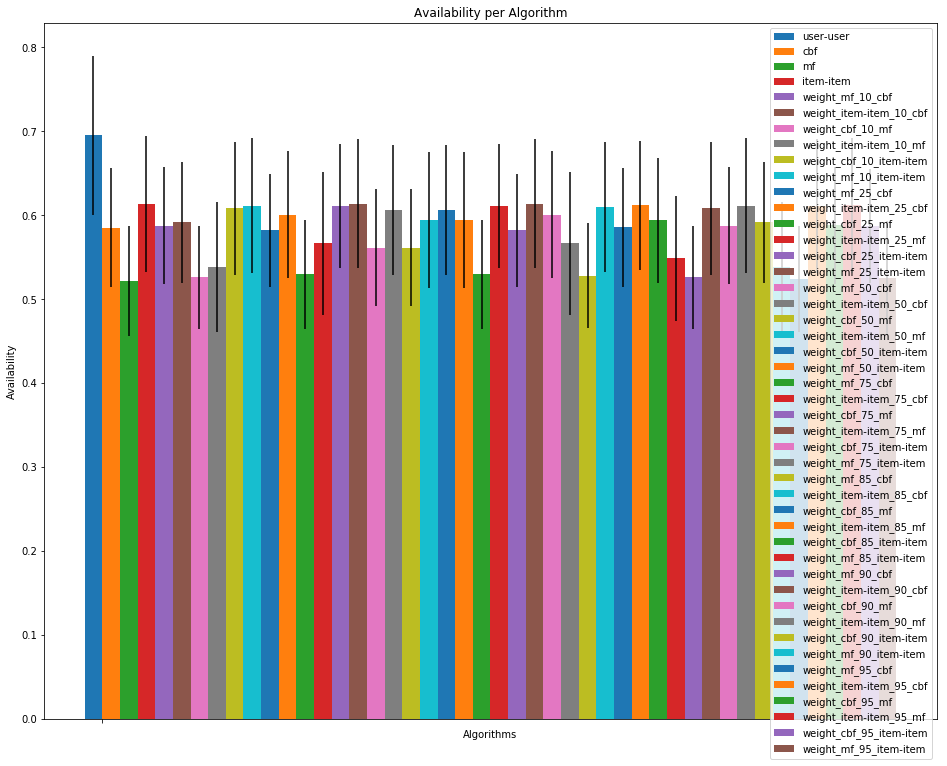

In [15]:
metric = results['Availability']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Availability')
ax.set_title('Availability per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [16]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.567862,0.624114,0.688028,0.761760,0.908394,0.918805,0.695152,0.500692,0.094819
cbf,0.510899,0.532006,0.566868,0.623718,0.796855,0.802512,0.585363,0.480483,0.070753
mf,0.468187,0.468187,0.498603,0.564393,0.684572,0.684572,0.521616,0.468187,0.065243
item-item,0.521144,0.558256,0.602912,0.665957,0.818278,0.825452,0.613373,0.453350,0.081052
weight_mf_10_cbf,0.510899,0.534974,0.566868,0.624356,0.796855,0.802512,0.587505,0.480483,0.069485
weight_item-item_10_cbf,0.510899,0.535662,0.575222,0.634883,0.741558,0.832648,0.591424,0.468213,0.072098
weight_cbf_10_mf,0.468187,0.477941,0.498603,0.564393,0.684572,0.684572,0.526142,0.468187,0.061492
weight_item-item_10_mf,0.468187,0.481192,0.498603,0.577398,0.784249,0.785121,0.538403,0.450936,0.077183
weight_cbf_10_item-item,0.519907,0.550665,0.597802,0.666393,0.788234,0.825452,0.608138,0.453350,0.079264
weight_mf_10_item-item,0.520207,0.556400,0.600882,0.680149,0.788234,0.825452,0.611547,0.453350,0.080111


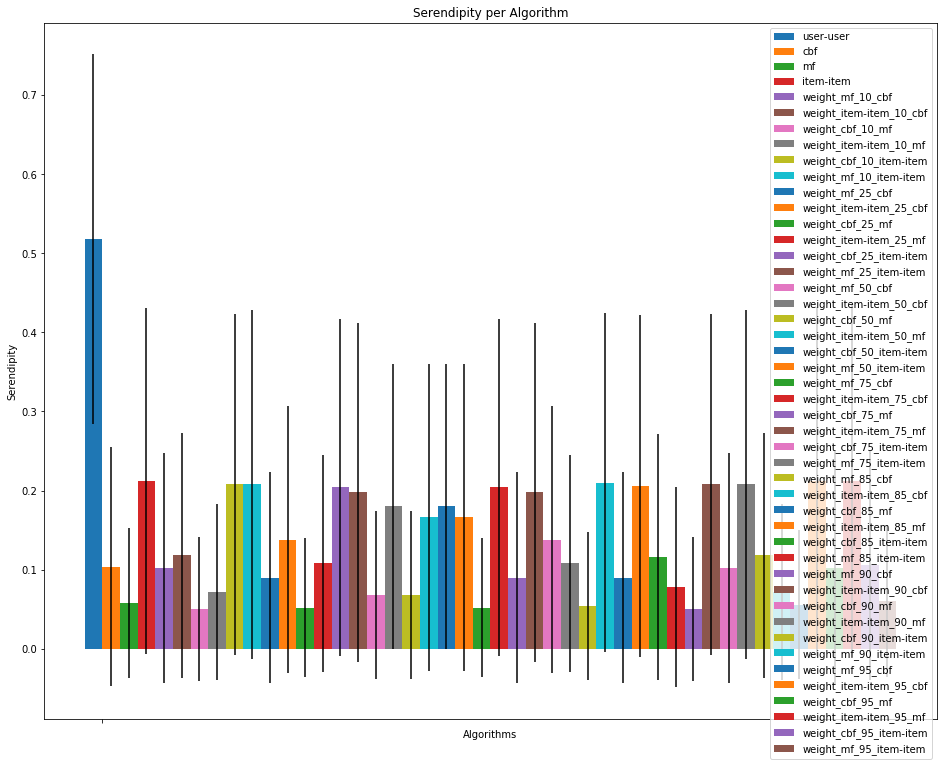

In [17]:
metric = results['Serendipity']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Serendipity')
ax.set_title('Serendipity per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [18]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.2,0.4,0.6,0.65,1.000,1.0,0.518,0.0,0.233401
cbf,0.0,0.0,0.0,0.20,0.602,0.8,0.104,0.0,0.150944
mf,0.0,0.0,0.0,0.20,0.202,0.4,0.058,0.0,0.095058
item-item,0.0,0.0,0.2,0.40,0.802,1.0,0.212,0.0,0.218760
weight_mf_10_cbf,0.0,0.0,0.0,0.20,0.404,0.8,0.102,0.0,0.145588
weight_item-item_10_cbf,0.0,0.0,0.0,0.20,0.404,0.8,0.118,0.0,0.155164
weight_cbf_10_mf,0.0,0.0,0.0,0.00,0.202,0.4,0.050,0.0,0.091104
weight_item-item_10_mf,0.0,0.0,0.0,0.20,0.400,0.4,0.072,0.0,0.111427
weight_cbf_10_item-item,0.0,0.0,0.2,0.40,0.802,1.0,0.208,0.0,0.215258
weight_mf_10_item-item,0.0,0.0,0.2,0.40,0.802,1.0,0.208,0.0,0.220762


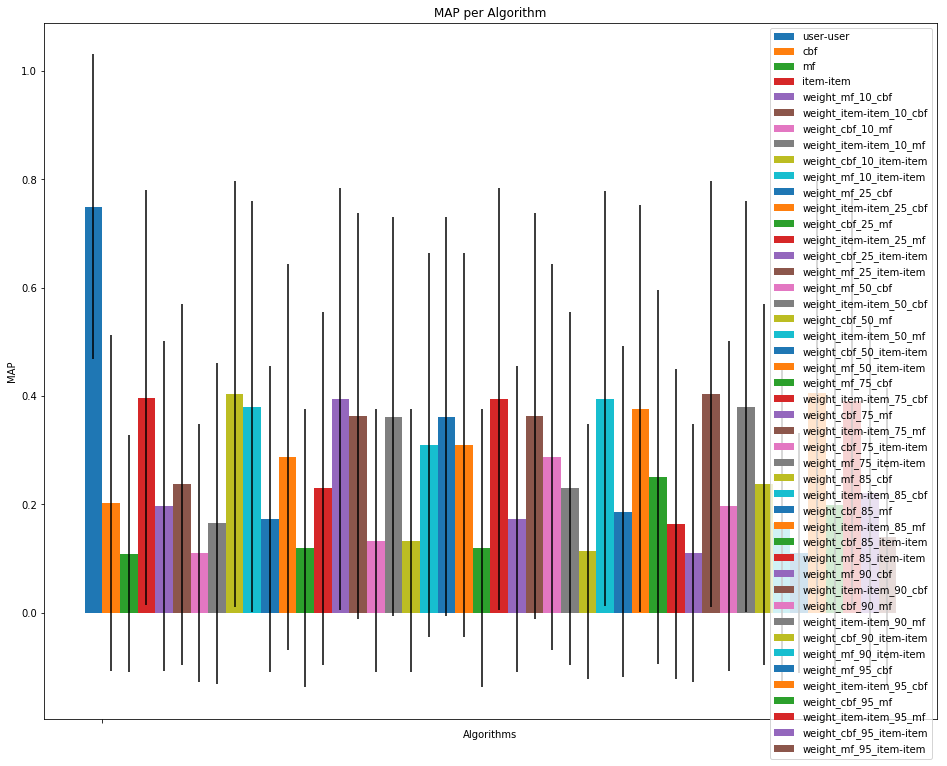

In [19]:
metric = results['MAP']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('MAP')
ax.set_title('MAP per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [20]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.3325,0.588889,0.850000,1.000000,1.0,1.0,0.749278,0.0,0.281404
cbf,0.0000,0.000000,0.000000,0.333333,1.0,1.0,0.202042,0.0,0.310513
mf,0.0000,0.000000,0.000000,0.200000,1.0,1.0,0.109167,0.0,0.218548
item-item,0.0000,0.000000,0.291667,0.712500,1.0,1.0,0.397000,0.0,0.383009
weight_mf_10_cbf,0.0000,0.000000,0.000000,0.333333,1.0,1.0,0.197458,0.0,0.304553
weight_item-item_10_cbf,0.0000,0.000000,0.000000,0.333333,1.0,1.0,0.236708,0.0,0.332785
weight_cbf_10_mf,0.0000,0.000000,0.000000,0.000000,1.0,1.0,0.110833,0.0,0.238297
weight_item-item_10_mf,0.0000,0.000000,0.000000,0.250000,1.0,1.0,0.165167,0.0,0.296443
weight_cbf_10_item-item,0.0000,0.000000,0.333333,0.805556,1.0,1.0,0.403653,0.0,0.392657
weight_mf_10_item-item,0.0000,0.000000,0.250000,0.712500,1.0,1.0,0.380222,0.0,0.378839


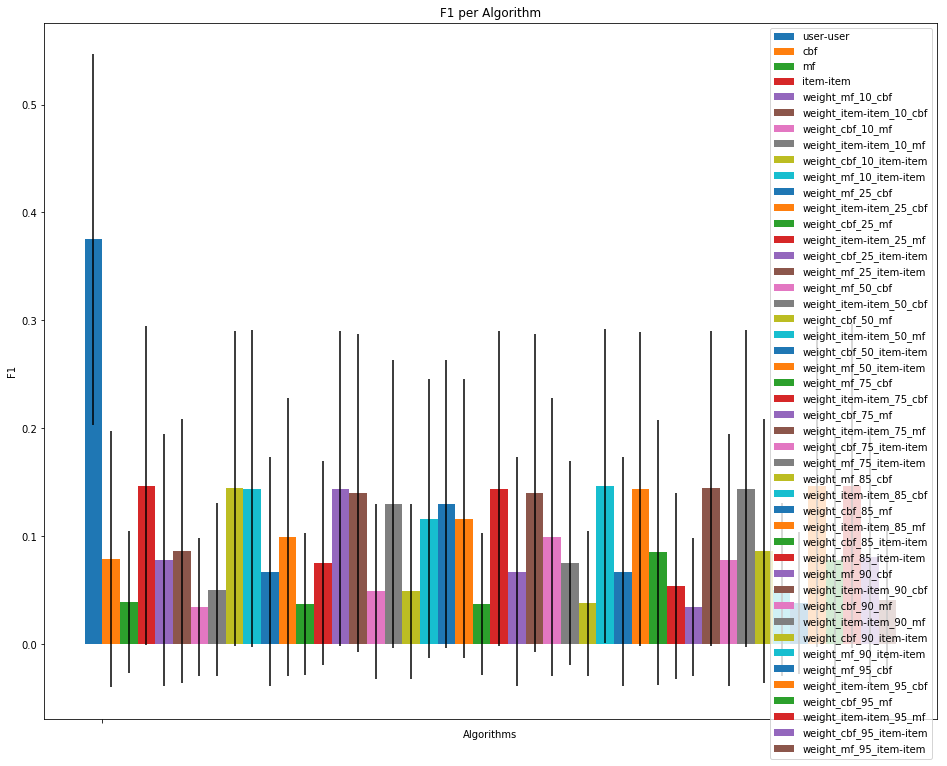

In [21]:
metric = results['F1']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('F1')
ax.set_title('F1 per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()


In [22]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.153846,0.246324,0.375000,0.500000,0.728000,0.800000,0.374980,0.0,0.171491
cbf,0.000000,0.000000,0.000000,0.153846,0.446667,0.666667,0.079245,0.0,0.118720
mf,0.000000,0.000000,0.000000,0.090909,0.200222,0.222222,0.039002,0.0,0.065534
item-item,0.000000,0.000000,0.142857,0.222222,0.556667,0.666667,0.146948,0.0,0.147872
weight_mf_10_cbf,0.000000,0.000000,0.000000,0.153846,0.446667,0.666667,0.078123,0.0,0.116972
weight_item-item_10_cbf,0.000000,0.000000,0.000000,0.153846,0.446667,0.666667,0.086412,0.0,0.122312
weight_cbf_10_mf,0.000000,0.000000,0.000000,0.000000,0.200222,0.222222,0.034310,0.0,0.063790
weight_item-item_10_mf,0.000000,0.000000,0.000000,0.112745,0.250833,0.333333,0.050656,0.0,0.080307
weight_cbf_10_item-item,0.000000,0.000000,0.142857,0.222222,0.556667,0.666667,0.144519,0.0,0.145981
weight_mf_10_item-item,0.000000,0.000000,0.142857,0.222222,0.556667,0.666667,0.144178,0.0,0.146813


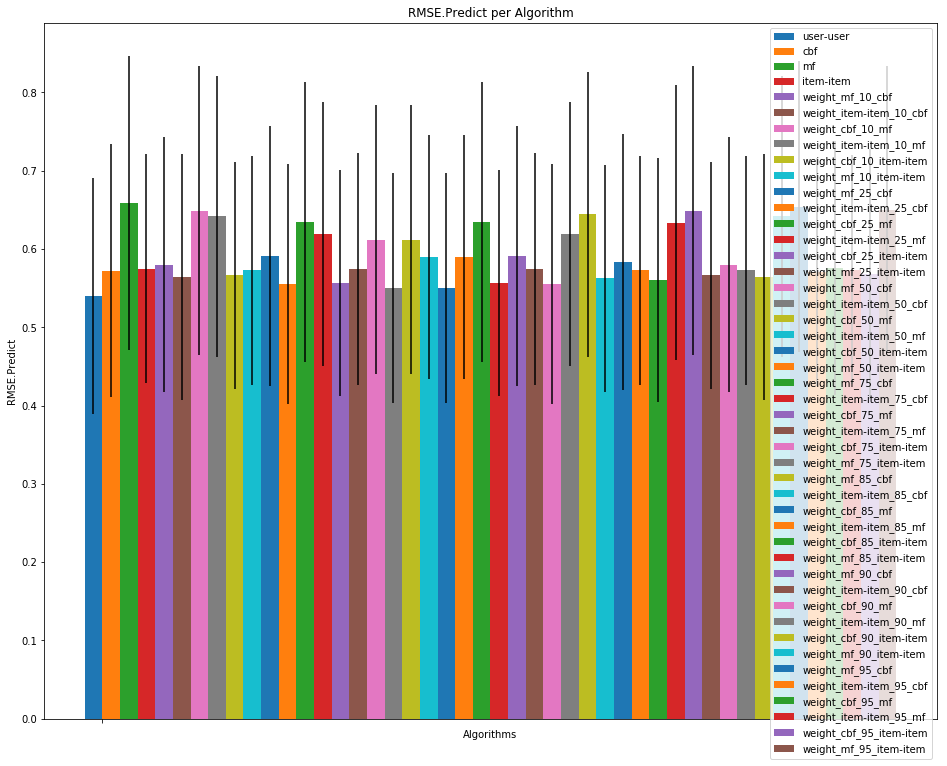

In [23]:
metric = results['RMSE.Predict']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.Predict')
ax.set_title('RMSE.Predict per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [24]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.379496,0.451870,0.521396,0.608613,0.961865,1.027937,0.539678,0.000000,0.150756
cbf,0.371323,0.458708,0.565546,0.665676,0.989574,1.017527,0.572387,0.266683,0.161299
mf,0.428535,0.524264,0.638710,0.746580,1.133340,1.258139,0.659029,0.311749,0.187732
item-item,0.393176,0.488066,0.549393,0.634057,0.992785,1.028632,0.574672,0.335113,0.146474
weight_mf_10_cbf,0.375247,0.464631,0.572717,0.670786,1.002426,1.018204,0.579637,0.268185,0.162968
weight_item-item_10_cbf,0.365560,0.454786,0.557591,0.649693,0.980619,1.011711,0.564200,0.258017,0.157545
weight_cbf_10_mf,0.424853,0.518230,0.629571,0.736707,1.117635,1.217099,0.649117,0.304594,0.184169
weight_item-item_10_mf,0.435175,0.507723,0.617689,0.719683,1.109672,1.183258,0.641603,0.307358,0.179418
weight_cbf_10_item-item,0.383945,0.484057,0.537851,0.629148,0.991000,1.013374,0.566152,0.331955,0.145122
weight_mf_10_item-item,0.391283,0.490134,0.545761,0.627825,0.996396,1.018312,0.572858,0.338838,0.146257


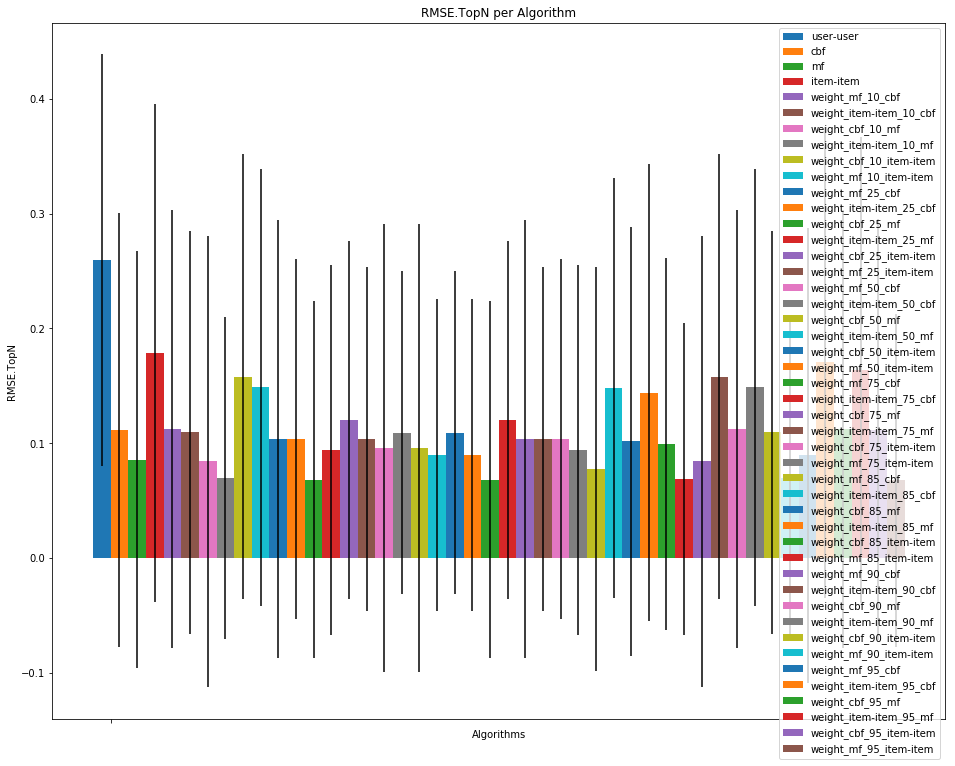

In [25]:
metric = results['RMSE.TopN']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.TopN')
ax.set_title('RMSE.TopN per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [26]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.055927,0.117116,0.230005,0.399643,0.680138,0.931245,0.259641,0.0,0.179276
cbf,0.000000,0.000000,0.000000,0.163600,0.641167,0.811303,0.111610,0.0,0.189255
mf,0.000000,0.000000,0.000000,0.057908,0.670296,0.885882,0.085722,0.0,0.181740
item-item,0.000000,0.000000,0.137183,0.293425,1.095363,1.143694,0.178520,0.0,0.216939
weight_mf_10_cbf,0.000000,0.000000,0.000000,0.158512,0.654174,0.816749,0.112131,0.0,0.190711
weight_item-item_10_cbf,0.000000,0.000000,0.000000,0.151291,0.584021,0.754257,0.109352,0.0,0.175789
weight_cbf_10_mf,0.000000,0.000000,0.000000,0.012524,0.866270,0.930114,0.084247,0.0,0.196639
weight_item-item_10_mf,0.000000,0.000000,0.000000,0.070675,0.548605,0.722421,0.069795,0.0,0.140459
weight_cbf_10_item-item,0.000000,0.000000,0.120579,0.236014,0.969288,1.032860,0.157858,0.0,0.193808
weight_mf_10_item-item,0.000000,0.000000,0.104031,0.224657,0.953364,1.027632,0.148664,0.0,0.190320


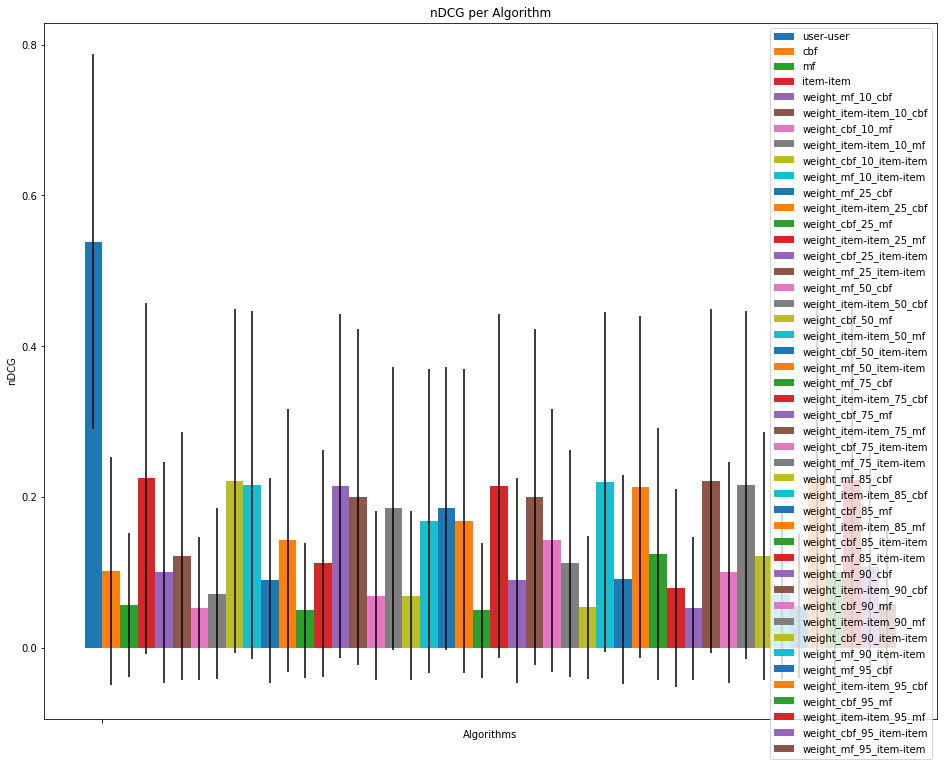

In [27]:
metric = results['nDCG']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('nDCG')
ax.set_title('nDCG per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [28]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.242076,0.363114,0.515847,0.732568,1.000000,1.000000,0.538416,0.0,0.248525
cbf,0.000000,0.000000,0.000000,0.205765,0.518268,0.757924,0.101620,0.0,0.150979
mf,0.000000,0.000000,0.000000,0.121038,0.363126,0.364263,0.057055,0.0,0.095502
item-item,0.000000,0.000000,0.197405,0.394809,0.880172,1.000000,0.224536,0.0,0.232487
weight_mf_10_cbf,0.000000,0.000000,0.000000,0.242076,0.486890,0.757924,0.099850,0.0,0.147035
weight_item-item_10_cbf,0.000000,0.000000,0.000000,0.242076,0.486890,0.757924,0.122046,0.0,0.164267
weight_cbf_10_mf,0.000000,0.000000,0.000000,0.102882,0.339149,0.363114,0.052190,0.0,0.094525
weight_item-item_10_mf,0.000000,0.000000,0.000000,0.129823,0.394809,0.394809,0.071556,0.0,0.113392
weight_cbf_10_item-item,0.000000,0.000000,0.242076,0.394809,0.880172,1.000000,0.221164,0.0,0.228661
weight_mf_10_item-item,0.000000,0.000000,0.152733,0.371038,0.880172,1.000000,0.216063,0.0,0.230439


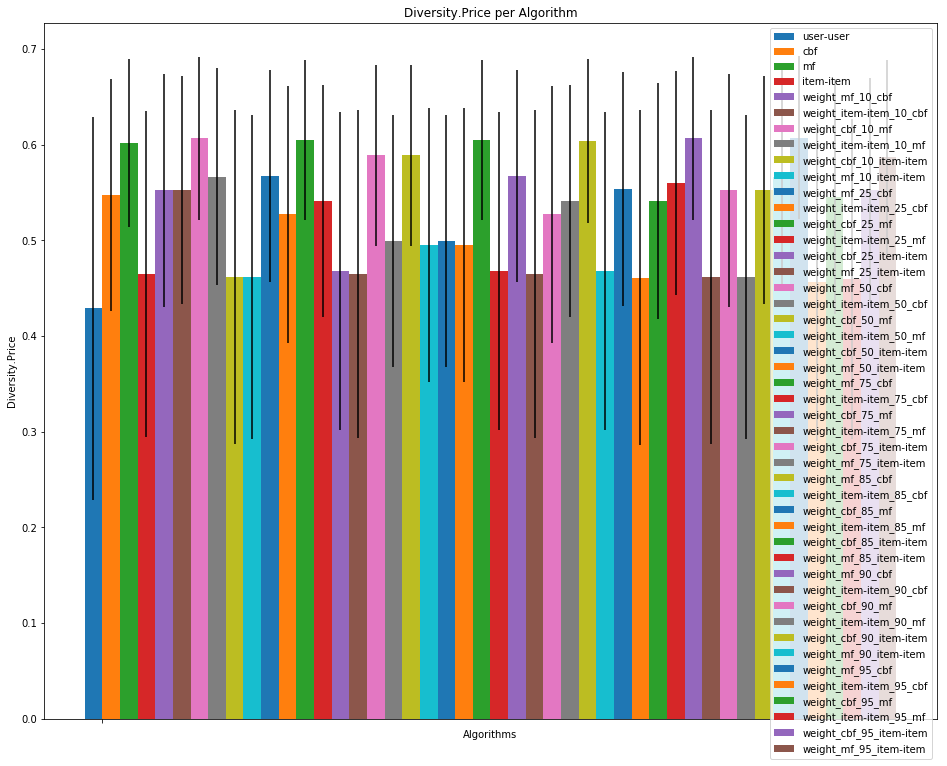

In [29]:
metric = results['Diversity.Price']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Price')
ax.set_title('Diversity.Price per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [30]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.160,0.32,0.48,0.56,0.7200,0.72,0.4288,0.00,0.200006
cbf,0.320,0.48,0.60,0.64,0.7200,0.72,0.5472,0.24,0.121178
mf,0.400,0.64,0.64,0.64,0.6400,0.64,0.6016,0.40,0.087985
item-item,0.240,0.32,0.48,0.64,0.7200,0.72,0.4648,0.00,0.170344
weight_mf_10_cbf,0.320,0.48,0.64,0.64,0.7200,0.72,0.5520,0.24,0.121589
weight_item-item_10_cbf,0.320,0.48,0.64,0.64,0.7200,0.72,0.5528,0.24,0.119248
weight_cbf_10_mf,0.400,0.64,0.64,0.64,0.6400,0.64,0.6064,0.32,0.085551
weight_item-item_10_mf,0.400,0.56,0.64,0.64,0.6400,0.64,0.5664,0.24,0.113521
weight_cbf_10_item-item,0.240,0.32,0.48,0.64,0.7200,0.72,0.4616,0.00,0.174119
weight_mf_10_item-item,0.240,0.32,0.48,0.64,0.7200,0.72,0.4616,0.00,0.169273


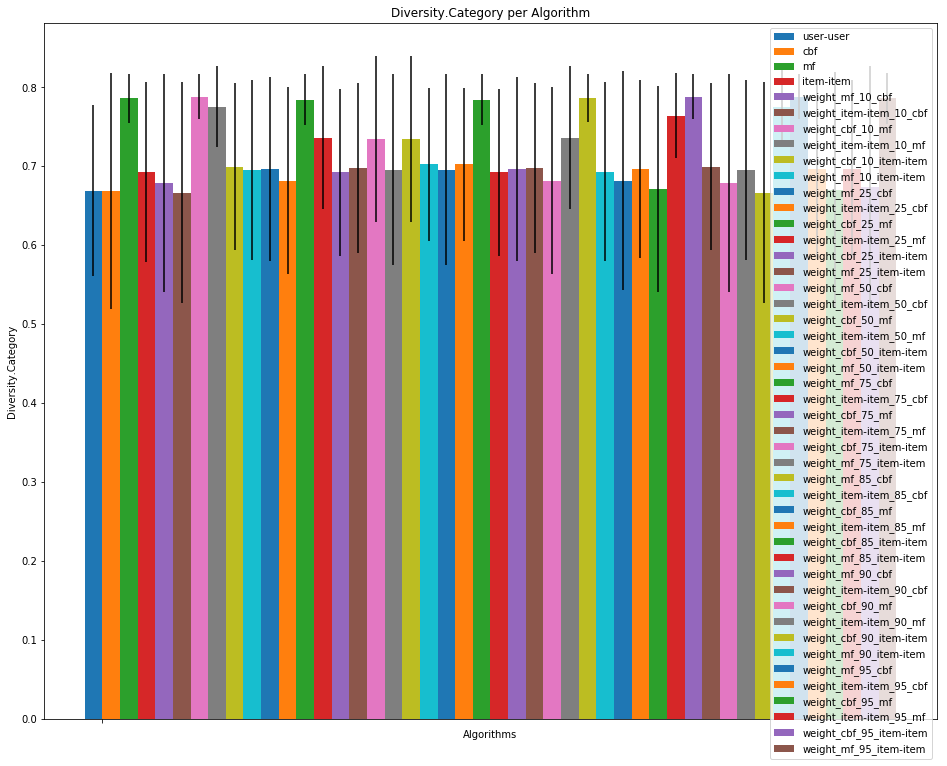

In [31]:
metric = results['Diversity.Category']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Category')
ax.set_title('Diversity.Category per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [32]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.560,0.56,0.72,0.72,0.8,0.8,0.6688,0.32,0.108234
cbf,0.560,0.64,0.72,0.72,0.8,0.8,0.6680,0.00,0.149399
mf,0.720,0.80,0.80,0.80,0.8,0.8,0.7856,0.72,0.030735
item-item,0.560,0.64,0.72,0.80,0.8,0.8,0.6928,0.32,0.113825
weight_mf_10_cbf,0.560,0.64,0.72,0.72,0.8,0.8,0.6784,0.00,0.138324
weight_item-item_10_cbf,0.552,0.56,0.72,0.72,0.8,0.8,0.6664,0.00,0.139968
weight_cbf_10_mf,0.720,0.80,0.80,0.80,0.8,0.8,0.7880,0.72,0.028566
weight_item-item_10_mf,0.720,0.80,0.80,0.80,0.8,0.8,0.7752,0.56,0.051468
weight_cbf_10_item-item,0.560,0.64,0.72,0.80,0.8,0.8,0.6992,0.32,0.105903
weight_mf_10_item-item,0.560,0.64,0.72,0.80,0.8,0.8,0.6952,0.32,0.114092


In [33]:
pd.DataFrame.from_dict(results['Coverage.Item'])

,cbf,item-item,mf,user-user,weight_cbf_10_item-item,weight_cbf_10_mf,weight_cbf_25_item-item,weight_cbf_25_mf,weight_cbf_50_item-item,weight_cbf_50_mf,...,weight_mf_50_cbf,weight_mf_50_item-item,weight_mf_75_cbf,weight_mf_75_item-item,weight_mf_85_cbf,weight_mf_85_item-item,weight_mf_90_cbf,weight_mf_90_item-item,weight_mf_95_cbf,weight_mf_95_item-item
0,0.205,0.53,0.045,0.755,0.495,0.045,0.445,0.07,0.355,0.11,...,0.11,0.32,0.07,0.17,0.05,0.115,0.045,0.085,0.045,0.06


In [34]:
pd.DataFrame.from_dict(results['Coverage.User'])

,cbf,item-item,mf,user-user,weight_cbf_10_item-item,weight_cbf_10_mf,weight_cbf_25_item-item,weight_cbf_25_mf,weight_cbf_50_item-item,weight_cbf_50_mf,...,weight_mf_50_cbf,weight_mf_50_item-item,weight_mf_75_cbf,weight_mf_75_item-item,weight_mf_85_cbf,weight_mf_85_item-item,weight_mf_90_cbf,weight_mf_90_item-item,weight_mf_95_cbf,weight_mf_95_item-item
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
